In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/f4/f0/21efef51304172736b823689aaf82f33dbc64f54e9b046b75f5212d5cee7/ftfy-6.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/fd/84/fd2ba7aafacbad3c4201d395674fc6348826569da3c0937e75505ead3528/wcwidth-0.2.13-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/54.4 kB ? eta -:--:--
   ------- -------------------------------- 10.2/54.4 kB ? eta -:--:--
   ------------------------------ --------- 41.0/54.4 kB 495.5 kB/s eta 0:00:01
   ---------------------------------------- 54.4/54.4 kB 566.6 kB/s eta 0:00:00
Using cached wcwidth-0.2.13-py2.py3-none-any.whl (34 kB)
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5
  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\loca

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\user\AppData\Local\Temp\pip-req-build-hwbcz8lz'


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!


In [4]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [5]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [6]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [5]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [8]:
print(dat["responses"].shape)

(1750, 8428)


In [6]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
import cv2
import clip
import torch
import numpy as np
from PIL import Image

import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


# Ensure you have access to a GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the CLIP model and preprocessing
model, preprocess = clip.load("ViT-L/14", device=device)

# Define categories and labels
categories = ["animate","inanimate"]
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in categories]).to(device)


width, height = 224, 224  # Example dimensions
dim = (width, height)

def preprocess_image_array(image_array):
    resized_image = cv2.resize(image_array, dim, interpolation=cv2.INTER_AREA)
    resized_3_channel_image = cv2.merge([resized_image, resized_image, resized_image])
    return torch.tensor(resized_3_channel_image).permute(2, 1, 0).to(device)

my_images = dat["stimuli"][0:30]
# Preprocess all images
image_inputs =  torch.stack([preprocess_image_array(image) for image in my_images])

# Perform classification
with torch.no_grad():
    image_features = model.encode_image(image_inputs)
    text_features = model.encode_text(text_inputs)
    logits_per_image, logits_per_text = model(image_inputs, text_inputs)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# Assign labels based on highest probability
labels = [categories[prob.argmax()] for prob in probs]

# Output the labels
for i, label in enumerate(labels):
    print(f"Image {i+1}: Label: {label}")
    print(probs[i])


100%|███████████████████████████████████████| 890M/890M [01:17<00:00, 12.0MiB/s]


Image 1: Label: animate
[0.95691633 0.04308372]
Image 2: Label: inanimate
[0.23944034 0.7605597 ]
Image 3: Label: animate
[0.9245043  0.07549568]
Image 4: Label: animate
[0.5378133  0.46218663]
Image 5: Label: animate
[0.53463763 0.4653623 ]
Image 6: Label: animate
[0.64666593 0.35333407]
Image 7: Label: animate
[0.84148306 0.15851703]
Image 8: Label: animate
[0.6239118 0.3760881]
Image 9: Label: inanimate
[0.467912 0.532088]
Image 10: Label: inanimate
[0.32395798 0.676042  ]
Image 11: Label: inanimate
[0.18822515 0.8117748 ]
Image 12: Label: inanimate
[0.22529824 0.7747018 ]
Image 13: Label: inanimate
[0.26563185 0.73436815]
Image 14: Label: animate
[0.84708583 0.15291412]
Image 15: Label: inanimate
[0.4284748 0.5715251]
Image 16: Label: inanimate
[0.2628932  0.73710674]
Image 17: Label: inanimate
[0.19920482 0.80079514]
Image 18: Label: animate
[0.90334684 0.09665316]
Image 19: Label: animate
[0.65817976 0.34182015]
Image 20: Label: inanimate
[0.14634036 0.8536597 ]
Image 21: Label: 

C:\Users\user\AppData\Local\Temp\ipykernel_5812\3776765578.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


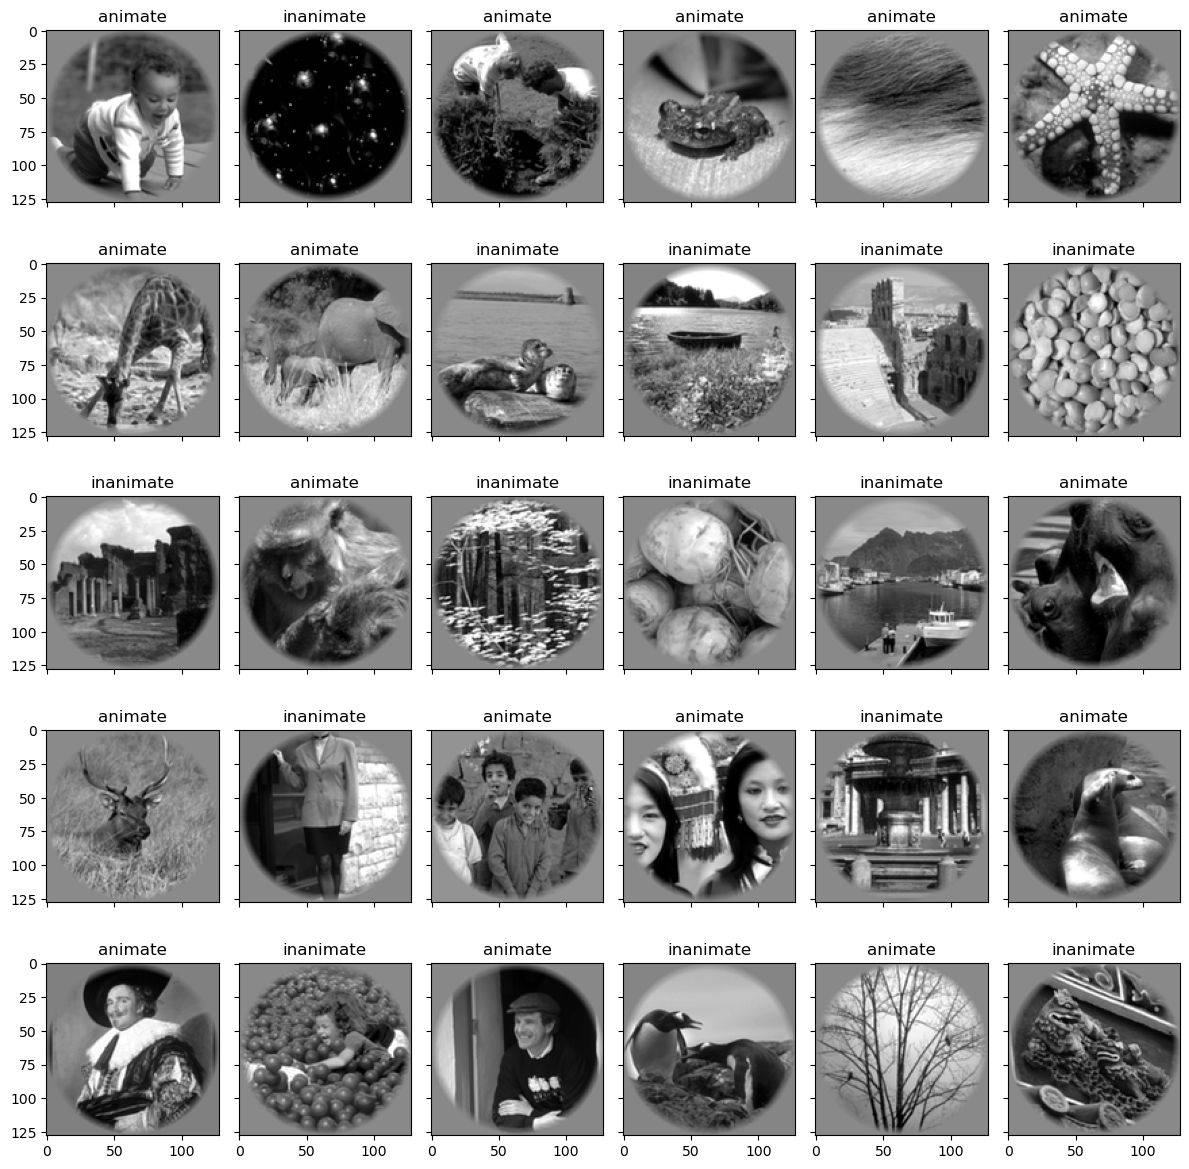

In [8]:
fig, axs = plt.subplots(5, 6, figsize=(12, 12), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"][0:30], labels):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()